## Image Dimensions BEFORE Preprocessing

Image dimensions for each class:
pituitary: number: 1457
WIDTH: min: 201, max: 1365, avg: 508.974605353466, HEIGHT: min: 202, max: 1365, avg: 508.95264241592315
notumor: number: 1595
WIDTH: min: 150, max: 1920, avg: 313.94796238244516, HEIGHT: min: 168, max: 1446, avg: 320.73354231974923
glioma: number: 1321
WIDTH: min: 512, max: 512, avg: 512.0, HEIGHT: min: 512, max: 512, avg: 512.0
meningioma: number: 1339
WIDTH: min: 180, max: 1275, avg: 493.3935772964899, HEIGHT: min: 207, max: 1427, avg: 495.23375653472743


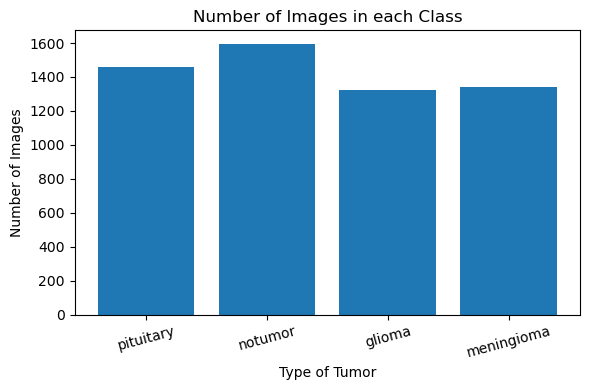

In [3]:
import os                     
from PIL import Image         
import matplotlib.pyplot as plt

base_directory  = "./Brain Cancer Dataset - Kaggle" 
train_directory = os.path.join(base_directory, "Training")

# get the dimensions for the images in the classes to see if we need to standardize
dimension_stats = {} 
for cls in os.listdir(train_directory):
    cls_path = os.path.join(train_directory, cls)
    # skip if it's not there
    if not os.path.isdir(cls_path):
        continue 
    sizes = [] 
    for fname in os.listdir(cls_path):
        if not fname.lower().endswith(".jpg"):
            continue
        img = Image.open(os.path.join(cls_path, fname))
        sizes.append(img.size)
    dimension_stats[cls] = sizes

print("Image dimensions for each class:")
for cls, sizes in dimension_stats.items():
    widths, heights = zip(*sizes)
    print(f"{cls:}: number: {len(sizes)}\n"
          f"WIDTH: min: {min(widths)}, max: {max(widths)}, avg: {sum(widths)/len(widths)}, "
          f"HEIGHT: min: {min(heights)}, max: {max(heights)}, avg: {sum(heights)/len(heights)}")

# plot to visualize the classes
class_counts = {cls: len(sizes) for cls, sizes in dimension_stats.items()}

# see how many images is in each class of the dataset
plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Number of Images in each Class")
plt.xlabel("Type of Tumor")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.tight_layout()

output_path = "class_balance.jpg"
plt.savefig(output_path, format="jpg", dpi=150) 

plt.show()

# IMPORTANT #
# we can see that there are varying averages, so we need to preprocess the dataset by standardizing
# to be better for the model training

## Preprocessing & Exploratory Data Analysis

In [1]:
%pip install tensorflow matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


### Preprocessing
#### Standardizing features

In [4]:
# preprocessing the dataset 
# importing libraries
import os
import cv2
import numpy as np

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # use CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # clahe documentation: https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply((img * 255).astype(np.uint8))
    return img

# set paths 
base_directory  = "./Brain Cancer Dataset - Kaggle" 
splits = ["Training", "Testing"]
output_directory  = "./preprocessed_data"

# go through training and testing sets
for split in splits:
    input_dir = os.path.join(base_directory, split)
    output_dir = os.path.join(output_directory, split)
    os.makedirs(output_dir, exist_ok=True)

    # get all class directories
    classes = [cls for cls in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, cls))]

    for cls in classes:
        in_class_dir = os.path.join(input_dir, cls)
        out_class_dir = os.path.join(output_dir, cls)
        os.makedirs(out_class_dir, exist_ok=True)

        image_files = [f for f in os.listdir(in_class_dir) if f.lower().endswith(".jpg")]
        print(f"{cls:}: {len(image_files)} images")

        for fname in image_files:
            in_path = os.path.join(in_class_dir, fname)
            out_path = os.path.join(out_class_dir, fname)
            img = preprocess_image(in_path)
            cv2.imwrite(out_path, img)

print("preprocessed images in: ./preprocessed_data/")

pituitary: 1457 images
notumor: 1595 images
glioma: 1321 images
meningioma: 1339 images
pituitary: 300 images
notumor: 405 images
glioma: 300 images
meningioma: 306 images
preprocessed images in: ./preprocessed_data/


### Exploratory Data Analysis

Classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
Number of images in each class:
pituitary: 1457 images
notumor: 1595 images
glioma: 1321 images
meningioma: 1339 images


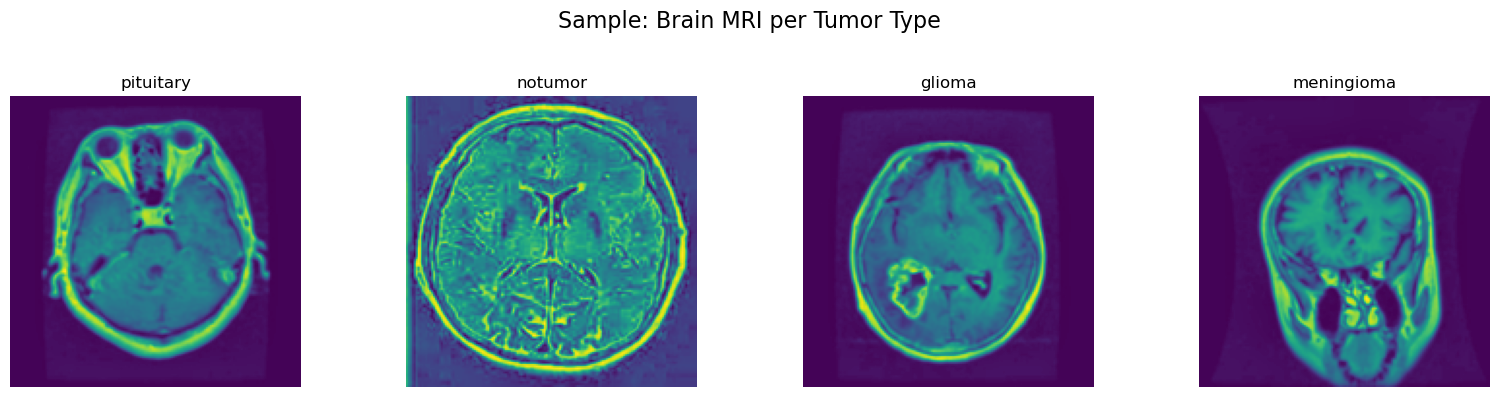

In [5]:
# importing the libraries needed for for the intial EDA
import os  
from PIL import Image 
import matplotlib.pyplot as plt 

# pulling from directories
# use preprocessed data
base_directory   = "./preprocessed_data" 
 # training split
train_directory  = os.path.join(base_directory, "Training") 

# get all the classes in training set
classes = [
    d for d in os.listdir(train_directory) 
    if os.path.isdir(os.path.join(train_directory, d))
]
print("Classes:", classes)

# count how many images is in each class
print("Number of images in each class:")
for cls in classes:
    cls_folder = os.path.join(train_directory, cls)
    # use jpg files 
    jpg_files = [
        f for f in os.listdir(cls_folder) 
        if f.lower().endswith(".jpg")
    ]
    print(f"{cls}: {len(jpg_files)} images")

# show one sample image for each class
fig, axes = plt.subplots(1, len(classes), figsize=(4*len(classes), 4))

# iterate through classes and axes 
for ax, cls in zip(axes, classes):
    cls_folder = os.path.join(train_directory, cls)
    # pick a sample image
    sample_file = next(
        f for f in os.listdir(cls_folder) 
        if f.lower().endswith(".jpg")
    )
    img_path = os.path.join(cls_folder, sample_file)
    
    # although image is already prepprocessed, resize to fit better when displaying the results
    # load the image and resize it to a standard thumbnail
    thumb = Image.open(img_path).resize((150, 150))

    # plot
    ax.imshow(thumb)
    # label with class name
    ax.set_title(f"{cls}", fontsize=12)   
    ax.axis("off")                        

plt.suptitle("Sample: Brain MRI per Tumor Type", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.9])     

# save the figure of sample 
output_path = "sample_mri_per_type.jpg"
plt.savefig(output_path, format="jpg", dpi=150)  


plt.show()

### Analyze Pixel Intensity Distribution
#### Used only one channel, because we tried with RGB earlier but only blue came up, so we thought it would be better to just focus and extract on one channel and plot the differences in the distribution of that

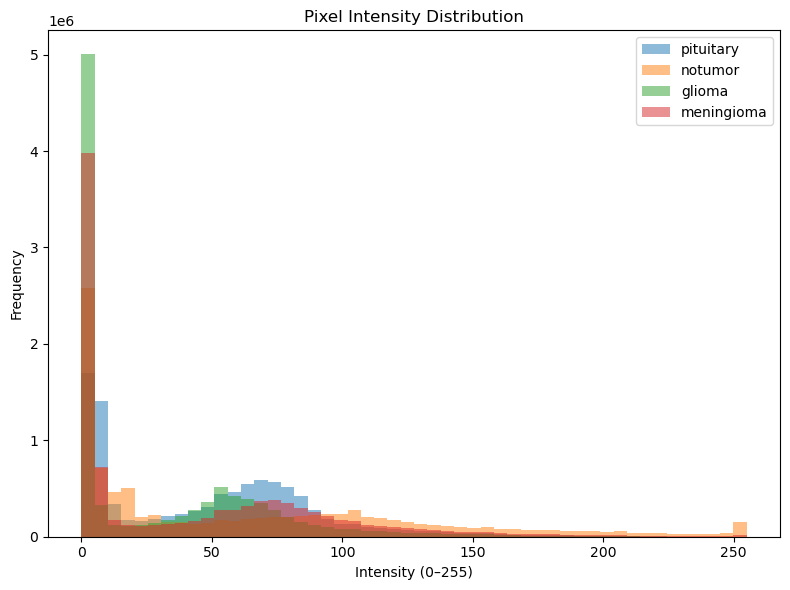

In [7]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

base_directory  = "./Brain Cancer Dataset - Kaggle" 
train_directory = os.path.join(base_directory, "Training")
classes = [d for d in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, d))]

# sample subset since there are many images, so it will take long to do all of it
np.random.seed(42)
subset_size = 200
sample_paths = {}
for cls in classes:
    folder = os.path.join(train_directory, cls)
    all_imgs = [os.path.join(folder, f) 
                for f in os.listdir(folder) 
                if f.lower().endswith(".jpg")]
    sample_paths[cls] = list(np.random.choice(all_imgs, subset_size, replace=False))

# plot histograms for each class
plt.figure(figsize=(8, 6))
for cls in classes:
    pixel_values = []
    for img_path in sample_paths[cls]:
        img = Image.open(img_path).resize((224, 224)).convert("RGB")
        arr = np.array(img)

        # only focus on blue channel since images are mostly blue
        blue_channel = arr[:, :, 2]  
        pixel_values.extend(blue_channel.flatten())

    plt.hist(pixel_values, bins=50, alpha=0.5, label=cls)

plt.title("Pixel Intensity Distribution")
plt.xlabel("Intensity (0–255)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# save to include in final report
plt.savefig("pixel_intensity_distribution.jpg", dpi=150)
plt.show()